In [3]:
import pandas as pd
import cudf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

%cd /data/dhk/physionet.org/files/mimiciv/2.2/hosp

/data/dhk/physionet.org/files/mimiciv/2.2/hosp


# 작업디렉토리 설정

In [4]:
# %cd C:\mimic-iv-2.2\mimic-iv-2.2\hosp

In [5]:
%cd /data/dhk/physionet.org/files/mimiciv/2.2/hosp

/data/dhk/physionet.org/files/mimiciv/2.2/hosp


# d_icd_diagnoses파일

In [6]:
df_d_icd_diagnoses = pd.read_csv('d_icd_diagnoses.csv')
df_d_icd_diagnoses.head()

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


# diagnoses_icd파일

In [7]:
df_diagnoses_icd = pd.read_csv("diagnoses_icd.csv")
df_diagnoses_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


# 고혈압&암환자

In [8]:
# 고혈압 진단 코드 정규식
high_bp_regex = r'^I1[0-5]$|^401'

#암 진단 코드 정규식  
#ICD-9 코드 분류 (140-239)
#ICD-10 코드 분류 (C00-C96, D00-D09)
cancer_regex = r'^(D(0[0-9])|C([0-8][0-9]|9[0-6])|(1[4-9][0-9]|2[0-3][0-9])).*'


# 암 진단 코드 추출
cancer_df = df_diagnoses_icd[df_diagnoses_icd['icd_code'].str.match(cancer_regex)]

# 암 진단을 받은 환자 ID 추출
cancer_patient_ids = cancer_df['subject_id'].unique()

# 암 진단을 받은 환자들의 데이터 추출
cancer_diagnoses_merged = pd.merge(df_diagnoses_icd, df_d_icd_diagnoses, on=['icd_code'])
cancer_patients_data = cancer_diagnoses_merged[cancer_diagnoses_merged['subject_id'].isin(cancer_patient_ids)]



# 암 및 고혈압을 동시에 가진 환자들의 데이터 추출 (첫 번째 진단만 포함)
cancer_high_bp_ids = cancer_patients_data[cancer_patients_data['icd_code'].str.match(high_bp_regex)]['subject_id'].unique()
cancer_high_bp_df = cancer_diagnoses_merged[(cancer_diagnoses_merged['subject_id'].isin(cancer_high_bp_ids)) & 
                                            (cancer_diagnoses_merged['seq_num'] == 1) & 
                                            (cancer_diagnoses_merged['icd_code'].str.match(cancer_regex))]

cancer_high_bp_df

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,icd_version_y,long_title
465,10001401,21544441,1,C675,10,10,Malignant neoplasm of bladder neck
658,10001877,25679292,1,2252,9,9,Benign neoplasm of cerebral meninges
1179,10002155,20345487,1,1628,9,9,Malignant neoplasm of other parts of bronchus ...
1364,10002348,22725460,1,C7931,10,10,Secondary malignant neoplasm of brain
2271,10003400,20214994,1,1543,9,9,"Malignant neoplasm of anus, unspecified site"
...,...,...,...,...,...,...,...
4859869,19999204,29046609,1,C220,10,10,Liver cell carcinoma
4859907,19999287,22997012,1,1629,9,9,"Malignant neoplasm of bronchus and lung, unspe..."
4859921,19999287,25875727,1,1623,9,9,"Malignant neoplasm of upper lobe, bronchus or ..."
4860097,19999784,23664472,1,C8339,10,10,"Diffuse large B-cell lymphoma, extranodal and ..."


# 첫입원기록만 가져옴

In [9]:
# subject_id로 그룹화하고 각 그룹에서 hadm_id가 가장 작은 행 선택
result = cancer_high_bp_df.loc[cancer_high_bp_df.groupby('subject_id')['hadm_id'].idxmin()]

# 필요시 인덱스 리셋
result.reset_index(drop=True, inplace=True)
result

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,icd_version_y,long_title
0,10001401,21544441,1,C675,10,10,Malignant neoplasm of bladder neck
1,10001877,25679292,1,2252,9,9,Benign neoplasm of cerebral meninges
2,10002155,20345487,1,1628,9,9,Malignant neoplasm of other parts of bronchus ...
3,10002348,22725460,1,C7931,10,10,Secondary malignant neoplasm of brain
4,10003400,20214994,1,1543,9,9,"Malignant neoplasm of anus, unspecified site"
...,...,...,...,...,...,...,...
9183,19996783,22140408,1,C259,10,10,"Malignant neoplasm of pancreas, unspecified"
9184,19997538,22701415,1,C20,10,10,Malignant neoplasm of rectum
9185,19999204,29046609,1,C220,10,10,Liver cell carcinoma
9186,19999287,22997012,1,1629,9,9,"Malignant neoplasm of bronchus and lung, unspe..."


# patients파일

In [10]:
df_patients = pd.read_csv("patients.csv")
df_patients.head(3)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN


# result와 patients 병합

In [11]:
merge2 = pd.merge(result,df_patients, on=['subject_id'])
merge2

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,icd_version_y,long_title,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10001401,21544441,1,C675,10,10,Malignant neoplasm of bladder neck,F,89,2131,2014 - 2016,NaN
1,10001877,25679292,1,2252,9,9,Benign neoplasm of cerebral meninges,M,89,2149,2008 - 2010,NaN
2,10002155,20345487,1,1628,9,9,Malignant neoplasm of other parts of bronchus ...,F,80,2128,2008 - 2010,2131-03-10
3,10002348,22725460,1,C7931,10,10,Secondary malignant neoplasm of brain,F,77,2112,2017 - 2019,NaN
4,10003400,20214994,1,1543,9,9,"Malignant neoplasm of anus, unspecified site",F,72,2134,2011 - 2013,2137-09-02
...,...,...,...,...,...,...,...,...,...,...,...,...
9183,19996783,22140408,1,C259,10,10,"Malignant neoplasm of pancreas, unspecified",M,89,2188,2017 - 2019,2188-05-21
9184,19997538,22701415,1,C20,10,10,Malignant neoplasm of rectum,M,53,2168,2017 - 2019,NaN
9185,19999204,29046609,1,C220,10,10,Liver cell carcinoma,M,61,2146,2017 - 2019,2146-08-29
9186,19999287,22997012,1,1629,9,9,"Malignant neoplasm of bronchus and lung, unspe...",F,71,2191,2008 - 2010,2197-09-02


# 환자나이 계산하기 위해 merge

In [12]:
df_admission = pd.read_csv("admissions.csv")
merge2_admission = pd.merge(merge2,df_admission, on=['subject_id','hadm_id'])
merge2_admission

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,icd_version_y,long_title,gender,anchor_age,anchor_year,...,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10001401,21544441,1,C675,10,10,Malignant neoplasm of bladder neck,F,89,2131,...,P872K3,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,NaN,NaN,0
1,10001877,25679292,1,2252,9,9,Benign neoplasm of cerebral meninges,M,89,2149,...,P47KFL,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,ENGLISH,MARRIED,WHITE,2149-05-21 10:58:00,2149-05-21 17:15:00,0
2,10002155,20345487,1,1628,9,9,Malignant neoplasm of other parts of bronchus ...,F,80,2128,...,P80515,EMERGENCY ROOM,DIED,Other,ENGLISH,MARRIED,WHITE,2131-03-09 19:14:00,2131-03-09 21:33:00,1
3,10002348,22725460,1,C7931,10,10,Secondary malignant neoplasm of brain,F,77,2112,...,P35WT5,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,2112-11-30 15:08:00,2112-11-30 23:24:00,0
4,10003400,20214994,1,1543,9,9,"Malignant neoplasm of anus, unspecified site",F,72,2134,...,P60ZCO,TRANSFER FROM SKILLED NURSING FACILITY,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9183,19996783,22140408,1,C259,10,10,"Malignant neoplasm of pancreas, unspecified",M,89,2188,...,P878WT,PHYSICIAN REFERRAL,HOME,Other,?,MARRIED,ASIAN - CHINESE,2188-04-22 08:36:00,2188-04-22 19:49:00,0
9184,19997538,22701415,1,C20,10,10,Malignant neoplasm of rectum,M,53,2168,...,P68URZ,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
9185,19999204,29046609,1,C220,10,10,Liver cell carcinoma,M,61,2146,...,P553JT,TRANSFER FROM HOSPITAL,HOME,Medicare,ENGLISH,SINGLE,WHITE,2146-05-30 14:10:00,2146-05-30 20:09:00,0
9186,19999287,22997012,1,1629,9,9,"Malignant neoplasm of bronchus and lung, unspe...",F,71,2191,...,P44WVR,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,2197-07-26 02:51:00,2197-07-26 05:00:00,0


# 입원시점에서 환자나이 계산

In [13]:
# 출생 연도 계산
print(merge2_admission[['anchor_year','anchor_age']].head(5))
print("~~")

##adgmit_age가 이상한 경우
#  환자의 나이가 89세 이상인 경우, 데이터 보호를 위해 모든 연령이 89세로 고정되어 있다는 것입니다.
merge2_admission = merge2_admission[merge2_admission['anchor_age']<89]

# admittime 열을 datetime 형식으로 변환
merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']

# 입원 연도 추출
admit_year = pd.to_datetime(merge2_admission['admittime']).dt.year

# 입원 시점의 나이 계산
merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']

#인덱스 초기화
merge2_admission.reset_index(drop=True, inplace=True)

#결과확인
print(merge2_admission[['subject_id', 'admittime', 'admit_age','birth_year','anchor_year','anchor_age']].head())

   anchor_year  anchor_age
0         2131          89
1         2149          89
2         2128          80
3         2112          77
4         2134          72
~~
   subject_id            admittime  admit_age  birth_year  anchor_year  \
0    10002155  2131-03-09 20:33:00         83        2048         2128   
1    10002348  2112-11-30 22:22:00         77        2035         2112   
2    10003400  2137-02-24 10:00:00         75        2062         2134   
3    10004235  2196-06-14 08:30:00         47        2149         2196   
4    10005024  2138-03-29 01:17:00         60        2078         2138   

   anchor_age  
0          80  
1          77  
2          72  
3          47  
4          60  


/tmp/ipykernel_272597/4117411835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']
/tmp/ipykernel_272597/4117411835.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']


# 예측했을때 써야할 피쳐들만 가지고왔는데 의논이 필요한듯

In [14]:
merge2_admission = merge2_admission[['subject_id','hadm_id','admit_age','seq_num','gender','dod','deathtime','insurance','language','marital_status','race','hospital_expire_flag','birth_year',]]
merge2_admission

,subject_id,hadm_id,admit_age,seq_num,gender,dod,deathtime,insurance,language,marital_status,race,hospital_expire_flag,birth_year
0,10002155,20345487,83,1,F,2131-03-10,2131-03-10 21:53:00,Other,ENGLISH,MARRIED,WHITE,1,2048
1,10002348,22725460,77,1,F,NaN,NaN,Medicare,ENGLISH,SINGLE,WHITE,0,2035
2,10003400,20214994,75,1,F,2137-09-02,NaN,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,2062
3,10004235,25970245,47,1,M,NaN,NaN,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,0,2149
4,10005024,25023471,60,1,M,2138-04-19,2138-04-19 11:30:00,Medicaid,ENGLISH,SINGLE,UNKNOWN,1,2078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8954,19995127,21801907,83,1,M,2138-06-12,NaN,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,2055
8955,19997538,22701415,53,1,M,NaN,NaN,Other,ENGLISH,MARRIED,WHITE,0,2115
8956,19999204,29046609,61,1,M,2146-08-29,NaN,Medicare,ENGLISH,SINGLE,WHITE,0,2085
8957,19999287,22997012,77,1,F,2197-09-02,NaN,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,2120


# death비율과 death하지 않은비율

In [15]:
merge2_admission['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    8608
1     351
Name: count, dtype: int64

# death 종양환자 평균나이 비교

In [16]:
print(f"종양환자의 평균나이 :{ merge2_admission['admit_age'].mean() }")

C_death = merge2_admission[merge2_admission['hospital_expire_flag']==1]
C_death_mean_age = C_death['admit_age'].mean()
print(f"death한 종양환자의 평균나이 :{C_death_mean_age}")

C_not_death = merge2_admission[merge2_admission['hospital_expire_flag']== 0]
C_not_death_mean_age = C_not_death['admit_age'].mean()
print(f"death하지않은 종양환자의 평균나이 :{C_not_death_mean_age}")

종양환자의 평균나이 :66.89541243442349
death한 종양환자의 평균나이 :68.84900284900284
death하지않은 종양환자의 평균나이 :66.81575278810409


# omr(환자 몸무게 혈압 등등) merge

In [17]:
omr = pd.read_csv("omr.csv")
# omr
merge3_omr = pd.merge(merge2_admission,omr, on=['subject_id'])
merge3_omr

,subject_id,hadm_id,admit_age,seq_num_x,gender,dod,deathtime,insurance,language,marital_status,race,hospital_expire_flag,birth_year,chartdate,seq_num_y,result_name,result_value
0,10002155,20345487,83,1,F,2131-03-10,2131-03-10 21:53:00,Other,ENGLISH,MARRIED,WHITE,1,2048,2129-08-31,1,Blood Pressure,113/62
1,10002155,20345487,83,1,F,2131-03-10,2131-03-10 21:53:00,Other,ENGLISH,MARRIED,WHITE,1,2048,2129-08-31,1,Weight (Lbs),117.8
2,10002155,20345487,83,1,F,2131-03-10,2131-03-10 21:53:00,Other,ENGLISH,MARRIED,WHITE,1,2048,2129-09-07,1,Blood Pressure,146/57
3,10002155,20345487,83,1,F,2131-03-10,2131-03-10 21:53:00,Other,ENGLISH,MARRIED,WHITE,1,2048,2129-09-07,1,BMI (kg/m2),23.8
4,10002155,20345487,83,1,F,2131-03-10,2131-03-10 21:53:00,Other,ENGLISH,MARRIED,WHITE,1,2048,2129-09-07,1,Height (Inches),59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924636,19999784,23664472,57,1,M,NaN,NaN,Other,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,2062,2122-03-29,1,Blood Pressure,109/78
924637,19999784,23664472,57,1,M,NaN,NaN,Other,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,2062,2122-03-29,1,BMI (kg/m2),26.8
924638,19999784,23664472,57,1,M,NaN,NaN,Other,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,2062,2122-03-29,1,Weight (Lbs),173.9
924639,19999784,23664472,57,1,M,NaN,NaN,Other,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,2062,2122-05-04,1,Blood Pressure,134/72


# pharmacy(환자 약물 처방 및 투약 내역) merge

In [18]:
pharmacy = pd.read_csv("pharmacy.csv")
pharmacy = pharmacy[['subject_id', 'hadm_id','poe_id','medication','frequency','doses_per_24_hrs']]
# pharmacy
merge4_pharmacy = pd.merge(merge3_omr,pharmacy, on=['subject_id','hadm_id'])
merge4_pharmacy

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

# prescriptions(약물 처방 기록) merge

In [ ]:
prescriptions = pd.read_csv("prescriptions.csv")
prescriptions = prescriptions[['subject_id', 'hadm_id','poe_id','drug','dose_val_rx','form_unit_disp','doses_per_24_hrs']]
merge5_prescriptions = pd.merge(merge4_pharmacy,prescriptions, on=['subject_id','hadm_id','poe_id'])
merge5_prescriptions

# 전처리한 csv파일 저장

In [ ]:
# merge5_prescriptions.to_csv('machine_dohun.csv', index=False)

# csv파일 불러오기

In [19]:
dh = pd.read_csv("machine_dohun.csv")
# dh = dh.to_pandas()

/tmp/ipykernel_272597/1392112362.py:1: DtypeWarning: Columns (5,6,9,17,18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  dh = pd.read_csv("machine_dohun.csv")


# 머신러닝에 내가 쓸 칼럼만 사용

In [20]:
dh = dh[['subject_id', 'hadm_id', 'admit_age', 'gender','insurance', 'language', 'marital_status', 'race',
       'hospital_expire_flag', 'medication', 'frequency','drug']] 

# marital_status칼럼 NaN값 핸들링

In [21]:
dh['marital_status'].fillna('Unknown', inplace=True)

/tmp/ipykernel_272597/3211302447.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dh['marital_status'].fillna('Unknown', inplace=True)


# medication 칼럼 NaN값 핸들링

In [22]:
dh['medication'].fillna('Unknown', inplace=True)

/tmp/ipykernel_272597/2179704666.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dh['medication'].fillna('Unknown', inplace=True)


# frequency 칼럼 NaN값 핸들링

In [23]:
dh['frequency'].fillna('Unknown', inplace=True)

/tmp/ipykernel_272597/1893148919.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dh['frequency'].fillna('Unknown', inplace=True)


In [24]:
# 라벨인코딩 후 스케일링

# 범주형데이터 라벨인코딩(범주형 데이터는 스케일 안해줄거임)

In [25]:
# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# marital_status 열 라벨 인코딩
dh['gender'] = label_encoder.fit_transform(dh['gender'])
dh['insurance'] = label_encoder.fit_transform(dh['insurance'])
dh['language'] = label_encoder.fit_transform(dh['language'])
dh['marital_status'] = label_encoder.fit_transform(dh['marital_status'])
dh['race'] = label_encoder.fit_transform(dh['race'])
dh['medication'] = label_encoder.fit_transform(dh['medication'])
dh['frequency'] = label_encoder.fit_transform(dh['frequency'])
dh['drug'] = label_encoder.fit_transform(dh['drug'])

# 스케일러 해줄 칼럼 : admit_age, 

In [26]:
# RobustScaler 인스턴스 생성
scaler = RobustScaler()

# 'feature1ㅋ' 칼럼 스케일링
dh['admit_age'] = scaler.fit_transform(dh[['admit_age']])

In [65]:
import matplotlib
import matplotlib.font_manager

[f.fname for f in matplotlib.font_manager.fontManager.ttflist]

['/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf',
 '/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf',
 '/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf',
 '/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf',
 '/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf',
 '/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf',
 '/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf',
 '/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf',
 '/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/S

findfont: Font family 'STIXGeneralBolIta' not found.
findfont: Font family 'STIXGeneralBolIta' not found.
/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'STIXGeneralBolIta' not found.
/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.c

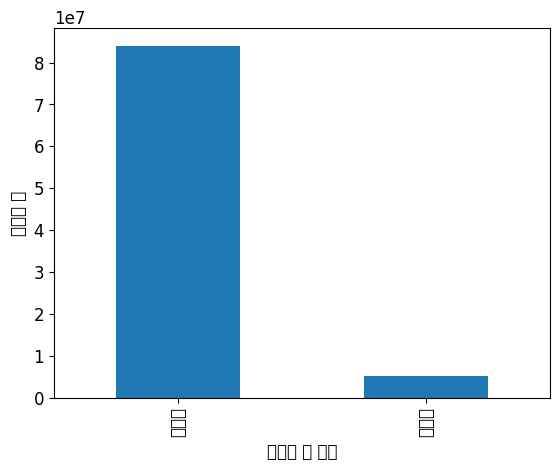

In [67]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 주피터 노트북 환경에 맞는 폰트 설정
path = '/usr/share/fonts/truetype/nanum/STIXSizTwoSym.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

# 사망자 수 비교 그래프 생성
dh['hospital_expire_flag'].value_counts().plot.bar()

# x축 라벨 설정
plt.xticks([0, 1], ['생존자', '사망자'])
plt.xlabel('사망자 수 비교')

# y축 라벨 설정
plt.ylabel('사망자 수')

# 그래프 표시
plt.show()


# under sampling

In [68]:
from sklearn.utils import resample
import cudf

In [70]:
df = cudf.DataFrame(dh)

df_majority = df[df['hospital_expire_flag'] == 0]
df_minority = df[df['hospital_expire_flag'] == 1]

# 다수 클래스 언더샘플링
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # 샘플을 복원하지 않음
                                   n_samples=len(df_minority),  # 소수 클래스와 동일한 수로 샘플링
                                   random_state=123)  # 재현성을 위한 랜덤 시드

# 소수 클래스와 결합
df_dh = cudf.concat([df_majority_downsampled, df_minority])

# 라벨 분포 확인
print(df_dh['hospital_expire_flag'].value_counts())

# print(df_dh['hospital_expire_flag'].value_counts().plot())

hospital_expire_flag
0    5175148
1    5175148
Name: count, dtype: int64


findfont: Font family 'STIXGeneralBolIta' not found.
findfont: Font family 'STIXGeneralBolIta' not found.
/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'STIXGeneralBolIta' not found.
/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.c

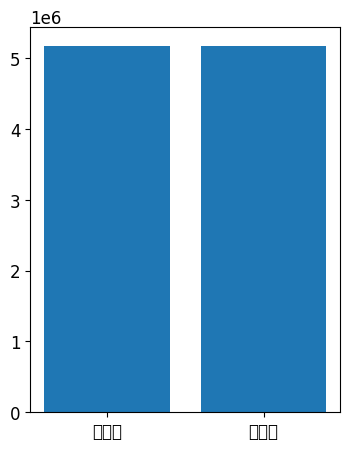

In [79]:
# 2. plt.bar() 함수 사용
value_counts = df_dh['hospital_expire_flag'].value_counts().to_numpy()
plt.figure(figsize=(4, 5))
plt.bar(range(len(value_counts)), value_counts)
plt.xticks(range(len(value_counts)), ['생존자', '사망자'])
# plt.xlabel('환자 상태')
# plt.ylabel('환자 수')
# plt.title('사망자 수 비교')
plt.show()

# 전처리한 파일 저장

In [ ]:
# df_dh.to_csv('process_dohun.csv', index=False)

In [3]:
df_dh = cudf.read_csv("process_dohun.csv")

In [4]:
df_dh = df_dh.drop('subject_id', axis=1)
df_dh = df_dh.drop('hadm_id', axis=1)
df_dh

,admit_age,gender,insurance,language,marital_status,race,hospital_expire_flag,medication,frequency,drug
0,-0.928571,1,2,1,1,28,0,50,95,34
1,-0.071429,0,2,1,1,28,0,806,16,860
2,-2.071429,0,2,1,1,28,0,50,95,72
3,-0.571429,1,2,1,2,28,0,15,16,1786
4,-1.000000,1,2,1,0,28,0,458,91,503
...,...,...,...,...,...,...,...,...,...,...
10350291,-0.785714,1,2,1,2,28,1,1552,121,1659
10350292,-0.785714,1,2,1,2,28,1,1552,121,1659
10350293,-0.785714,1,2,1,2,28,1,1552,121,1659
10350294,-0.785714,1,2,1,2,28,1,1552,121,1659


# 모델링

In [5]:
# import cupy
from cuml.ensemble import RandomForestClassifier


from cuml.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## RandomForestClassifier

In [7]:
y = df_dh['hospital_expire_flag'] 
X = df_dh.drop('hospital_expire_flag', axis=1) # 'label' 열을 제외한 나머지 열을 X로 사용


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

X_train = X_train.to_cupy()
X_test = X_test.to_cupy()
y_train = y_train.to_cupy()
y_test = y_test.to_cupy()

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# X_train = X_train.to_pandas()
# X_test = X_test.to_pandas()
# y_train = y_train.to_pandas()
# y_test = y_test.to_pandas()


# 모델 및 그리드 서치 설정
randomForest = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],  # 정수형 값
    'max_depth': [10, 20, 30],        # 정수형 값
    'min_samples_split': [2, 5, 10]   # 정수형 값
}
randomForest_grid_search = GridSearchCV(
    randomForest,
    param_grid=param_grid,
    scoring ='accuracy',
    cv=3,
    return_train_score=True,
    verbose=3,
    n_jobs=20
)


#-------------------------------------------------------------
### 랜덤포레스트
# 모델 학습
print("random_forest 시작!")
randomForest_grid_search.fit(X_train.get(), y_train.get())

# 최적 모델로 예측
randomForest_best_model = randomForest_grid_search.best_estimator_
randomForest_y_pred = randomForest_best_model.predict(X_test)
print("random_forest 끝!")


random_forest 시작!
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 3/3] END max_depth=10, min_samples_split=2, n_estimators=200;, score=(train=0.710, test=0.710) total time=26.8min
[CV 1/3] END max_depth=20, min_samples_split=2, n_estimators=300;, score=(train=0.815, test=0.815) total time=48.7min


/home/dhkim/anaconda3/envs/mach/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3] END max_depth=10, min_samples_split=5, n_estimators=200;, score=(train=0.711, test=0.710) total time=26.8min
[CV 2/3] END max_depth=20, min_samples_split=2, n_estimators=300;, score=(train=0.816, test=0.816) total time=48.8min
[CV 1/3] END max_depth=10, min_samples_split=5, n_estimators=200;, score=(train=0.712, test=0.712) total time=26.5min
[CV 1/3] END max_depth=20, min_samples_split=2, n_estimators=200;, score=(train=0.816, test=0.815) total time=32.5min
[CV 2/3] END max_depth=30, min_samples_split=2, n_estimators=100;, score=(train=0.834, test=0.834) total time=16.9min
[CV 2/3] END max_depth=10, min_samples_split=5, n_estimators=200;, score=(train=0.710, test=0.710) total time=26.7min
[CV 2/3] END max_depth=20, min_samples_split=2, n_estimators=200;, score=(train=0.816, test=0.815) total time=32.8min
[CV 3/3] END max_depth=30, min_samples_split=2, n_estimators=100;, score=(train=0.833, test=0.832) total time=17.1min
[CV 3/3] END max_depth=10, min_samples_split=2, n_estima

In [ ]:
# # 저장된 모델 불러오기
# load_randomForest_best_model = joblib.load('randomForest_best_model.pkl')

In [23]:
# randomForest_y_pred = randomForest_best_model.predict(X_test)

In [24]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (8280236, 9)
X_test shape: (2070060, 9)
y_train shape: (8280236,)
y_test shape: (2070060,)


In [25]:
X_train

array([[-7.1428575e-02,  0.0000000e+00,  1.0000000e+00, ...,
         1.0070000e+03,  1.8000000e+01,  1.0710000e+03],
       [-5.0000000e-01,  0.0000000e+00,  2.0000000e+00, ...,
         8.0600000e+02,  1.6000000e+01,  8.6000000e+02],
       [ 1.2857143e+00,  0.0000000e+00,  1.0000000e+00, ...,
         1.6130000e+03,  1.6000000e+01,  9.2800000e+02],
       ...,
       [ 5.7142860e-01,  0.0000000e+00,  2.0000000e+00, ...,
         1.2030000e+03,  8.3000000e+01,  1.2750000e+03],
       [ 7.1428575e-02,  0.0000000e+00,  2.0000000e+00, ...,
         1.3110000e+03,  1.6000000e+01,  1.3930000e+03],
       [ 1.4285715e-01,  1.0000000e+00,  1.0000000e+00, ...,
         9.4900000e+02,  9.3000000e+01,  1.0080000e+03]], dtype=float32)

In [27]:
# # 랜덤 포레스트 모델의 피처 중요도 출력
# feature_importances =  randomForest_best_model.feature_importances_
# feature_names = df_dh.columns  # 피처 이름 가져오기

# print("Feature Importances:")
# for i, importance in enumerate(feature_importances):
#     print(f"Feature {feature_names[i]}: {importance:.4f}")


[CV 2/3] END max_depth=30, min_samples_split=5, n_estimators=300;, score=(train=0.835, test=0.834) total time=13.1min
[CV 1/3] END max_depth=20, min_samples_split=10, n_estimators=300;, score=(train=0.815, test=0.815) total time=12.4min
[CV 2/3] END max_depth=30, min_samples_split=5, n_estimators=100;, score=(train=0.835, test=0.834) total time= 4.3min
[CV 3/3] END max_depth=30, min_samples_split=5, n_estimators=300;, score=(train=0.833, test=0.832) total time=12.5min
[CV 1/3] END max_depth=30, min_samples_split=10, n_estimators=200;, score=(train=0.833, test=0.832) total time= 8.1min
[CV 2/3] END max_depth=20, min_samples_split=10, n_estimators=100;, score=(train=0.817, test=0.817) total time= 4.1min
[CV 3/3] END max_depth=20, min_samples_split=10, n_estimators=300;, score=(train=0.815, test=0.814) total time=12.5min
[CV 1/3] END max_depth=30, min_samples_split=5, n_estimators=200;, score=(train=0.834, test=0.833) total time= 8.8min
[CV 2/3] END max_depth=30, min_samples_split=10, n_e

In [8]:
import cuml

cu_score = cuml.metrics.accuracy_score( y_test, randomForest_y_pred )
print(cu_score)

# 정확도 계산
accuracy = accuracy_score(y_test.get(), randomForest_y_pred.get())
print("Accuracy:", accuracy)

# F1 스코어 계산
f1 = f1_score(y_test.get(), randomForest_y_pred.get())
print("F1 Score:", f1)

0.8335115909576416
Accuracy: 0.8335115890360666
F1 Score: 0.8430269869458261


In [9]:
y_test

array([1., 0., 1., ..., 0., 0., 1.], dtype=float32)

In [1]:
len(randomForest_y_pred)

NameError: name 'randomForest_y_pred' is not defined

In [11]:
import pandas as pd

# randomForest_y_pred를 Pandas DataFrame으로 변환
y_pred_df = pd.DataFrame(randomForest_y_pred.get())

# CSV 파일로 저장
y_pred_df.to_csv('randomForest_y_pred.csv', index=False, header=False)

[CV 3/3] END max_depth=30, min_samples_split=5, n_estimators=300;, score=(train=0.833, test=0.833) total time=34.4min
[CV 1/3] END max_depth=30, min_samples_split=10, n_estimators=300;, score=(train=0.836, test=0.835) total time=22.3min
[CV 2/3] END max_depth=30, min_samples_split=10, n_estimators=300;, score=(train=0.835, test=0.835) total time=21.8min
[CV 3/3] END max_depth=30, min_samples_split=10, n_estimators=300;, score=(train=0.833, test=0.833) total time=21.5min
